# 2.Preprocess data

In [316]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os, json
sns.set(style="whitegrid", context="notebook")

## 2.1 Read raw data

In [317]:
file_path = '../data/raw/aug_train.csv' 

data = np.genfromtxt(
    file_path,
    delimiter=',',
    skip_header=1,    # Skip header row
    dtype=str         
)


In [318]:
with open(file_path, "r", encoding='utf-8') as file:
    columns = file.readline().split(",")
columns = [item.strip() for item in columns if item.strip()]
columns

['enrollee_id',
 'city',
 'city_development_index',
 'gender',
 'relevent_experience',
 'enrolled_university',
 'education_level',
 'major_discipline',
 'experience',
 'company_size',
 'company_type',
 'last_new_job',
 'training_hours',
 'target']

## 2.2 Helper utilities

In [319]:
def print_table_from_col_arrays(col_arrays, columns, cols=None, limit=10, max_width=18):
    cols = columns if cols is None else cols
    if not col_arrays:
        print("col_arrays is empty")
        return
    n = len(next(iter(col_arrays.values())))
    k = min(limit, n)

    def _trunc(s):
        s = str(s)
        return s if len(s) <= max_width else (s[: max_width - 3] + "...")

    trunc_vec = np.vectorize(_trunc)

    values_per_col = {}
    widths = []
    for c in cols:
        vals = col_arrays[c][:k].astype(str)
        vals = trunc_vec(vals)
        w = int(max([len(c)] + [len(v) for v in vals.tolist()]))
        widths.append(w)
        values_per_col[c] = vals

    header = " | ".join([f"{c:<{w}}" for c, w in zip(cols, widths)])
    sep = "-+-".join(["-" * w for w in widths])
    print(header)
    print(sep)
    for i in range(k):
        row = " | ".join([f"{values_per_col[c][i]:<{w}}" for c, w in zip(cols, widths)])
        print(row)
    if k < n:
        print(f"... ({n - k} more rows)")

In [320]:
# Helpers: parsing + type detection (NumPy only)

col_idx = {c: i for i, c in enumerate(columns)}
col_arrays = {c: data[:, i] for c, i in col_idx.items()}


print_table_from_col_arrays(col_arrays, columns)

enrollee_id | city     | city_development_index | gender | relevent_experience | enrolled_university | education_level | major_discipline | experience | company_size | company_type   | last_new_job | training_hours | target
------------+----------+------------------------+--------+---------------------+---------------------+-----------------+------------------+------------+--------------+----------------+--------------+----------------+-------
8949        | city_103 | 0.92                   | Male   | Has relevent ex...  | no_enrollment       | Graduate        | STEM             | >20        |              |                | 1            | 36             | 1.0   
29725       | city_40  | 0.7759999999999999     | Male   | No relevent exp...  | no_enrollment       | Graduate        | STEM             | 15         | 50-99        | Pvt Ltd        | >4           | 47             | 0.0   
11561       | city_21  | 0.624                  |        | No relevent exp...  | Full time course    | G

In [321]:
def safe_float_vec(vec):
    out = np.empty(vec.shape, dtype=float)
    for i, v in enumerate(vec):
        try:
            out[i] = float(v)
        except Exception:
            out[i] = np.nan
    return out

## 2.3 Preprocessing plan 

Based on EDA in notebook 01:

1. I won't use enroll ID because it doesn't make any sense.
2. Try preprocessing numeric data first.
3. Then preprocess catetorical data.
4. Save to csv file and go to next step (train model).


### 2.3.1 Preprocess numeric data

In [322]:
columns

['enrollee_id',
 'city',
 'city_development_index',
 'gender',
 'relevent_experience',
 'enrolled_university',
 'education_level',
 'major_discipline',
 'experience',
 'company_size',
 'company_type',
 'last_new_job',
 'training_hours',
 'target']

In [323]:
city_dev_idx_col = safe_float_vec(col_arrays["city_development_index"])
print("Number of NaN value:", np.isnan(city_dev_idx_col).sum())

city_dev_idx_col

Number of NaN value: 0


array([0.92 , 0.776, 0.624, ..., 0.92 , 0.802, 0.855])

Number of NaN value: 0


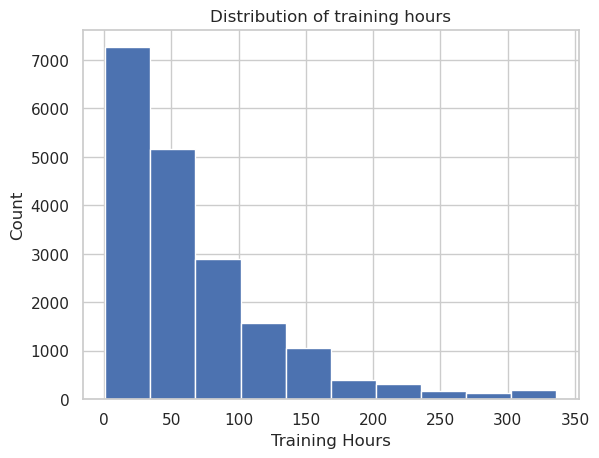

In [324]:
training_hour_col = safe_float_vec(col_arrays["training_hours"])
print("Number of NaN value:", np.isnan(training_hour_col).sum())
plt.hist(training_hour_col)
plt.title("Distribution of training hours")
plt.xlabel("Training Hours")
plt.ylabel("Count")
plt.show()

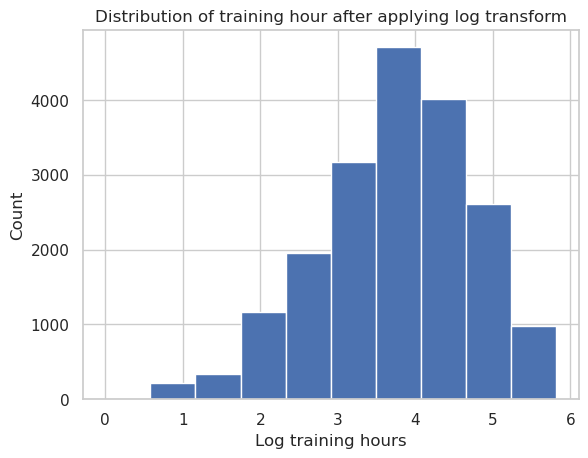

In [325]:

training_hour_log = np.log(training_hour_col + 1e-8)
training_hour_log

plt.title("Distribution of training hour after applying log transform")
plt.hist(training_hour_log)
plt.xlabel("Log training hours")
plt.ylabel("Count")
plt.show()

### 2.3.2 Preprocess categorical data

#### 2.3.2.1 Gender
Because missing gender values (NULL) and "Other" both represent cases where the respondent does not identify as strictly male or female — either because they prefer not to disclose, or because the information was not provided — we group them into the same category.

Therefore, I encode gender as:

- Male → 1
- Female → –1
- Other / Missing (NULL) → 0

This encoding preserves the distinction between the two major gender groups while keeping all non-binary or missing responses neutral.

In [326]:
gender_col = col_arrays["gender"].astype(str)
# np.isnan(gender_col).sum()
# np.unique(gender_col)
gender_col = np.where(gender_col == "Male", 1,
           np.where(gender_col == "Female", -1, 0))
np.unique(gender_col), gender_col

(array([-1,  0,  1]), array([1, 1, 0, ..., 1, 1, 0]))

#### 2.3.2.2 Relevent experience

Im gonna encode:
- Has relevent expericence : 1
- No relevent experience: 0

In [327]:
re_exp_col = col_arrays["relevent_experience"].astype(str)
np.unique(re_exp_col)

array(['Has relevent experience', 'No relevent experience'], dtype='<U23')

In [328]:
re_exp_col[:5]

array(['Has relevent experience', 'No relevent experience',
       'No relevent experience', 'No relevent experience',
       'Has relevent experience'], dtype='<U23')

In [329]:
re_exp_col = np.where(re_exp_col == "Has relevent experience", 1, 0)
re_exp_col[:5]

array([1, 0, 0, 0, 1])

#### 2.3.2.3 Enrolled univeristy

In [330]:
en_uni_col = col_arrays["enrolled_university"].astype(str)
np.unique(en_uni_col)

array(['', 'Full time course', 'Part time course', 'no_enrollment'],
      dtype='<U23')

Because blank values ("") indicate missing information and are functionally similar to "no_enrollment" (no enrollment data provided), I merge them.

Then I encode enrollment status by level of engagement:

- Full-time course: 2
- Part-time course: 1
- No enrollment / missing: 0

In [331]:
en_uni_col[:5]

array(['no_enrollment', 'no_enrollment', 'Full time course', '',
       'no_enrollment'], dtype='<U23')

In [332]:
en_uni_col = np.where(en_uni_col == "Full time course", 2, 
                      np.where(en_uni_col == "Part time course", 1, 0))
en_uni_col[:5]

array([0, 0, 2, 0, 0])

#### 2.3.2.4 Enducation level

In [333]:
edu_level_col = col_arrays["education_level"].astype(str)
np.unique(edu_level_col)

array(['', 'Graduate', 'High School', 'Masters', 'Phd', 'Primary School'],
      dtype='<U23')

Education level is an ordinal feature, so I encode it based on increasing academic attainment. Missing values ("") are treated as "Unknown".\
The final encoding is:
- Unknown = 0
- Primary School = 1
- High School = 2 
- Graduate = 3 
- Masters = 4
- PhD = 5.

In [334]:
edu_level_col[:5]

array(['Graduate', 'Graduate', 'Graduate', 'Graduate', 'Masters'],
      dtype='<U23')

In [335]:
edu_level_col = col_arrays["education_level"].astype(str)

# handle missing
edu_level_col = np.where(edu_level_col == "", "Unknown", edu_level_col)

edu_level_col = np.where(edu_level_col == "Primary School", 1,
           np.where(edu_level_col == "High School", 2,
           np.where(edu_level_col == "Graduate", 3,
           np.where(edu_level_col == "Masters", 4,
           np.where(edu_level_col == "Phd", 5, 0)))))
edu_level_col[:5]

array([3, 3, 3, 3, 4])

#### 2.3.2.5 Major discipline

In [336]:
major_col = col_arrays["major_discipline"].astype(str)
np.unique(major_col)

array(['', 'Arts', 'Business Degree', 'Humanities', 'No Major', 'Other',
       'STEM'], dtype='<U23')

Because, In the EDA part in notebook 01, STEM overwhelmed the dataset, so that I encode:
- STEM = 1
- Non-STEM = 0

In [337]:
major_col[:5]

array(['STEM', 'STEM', 'STEM', 'Business Degree', 'STEM'], dtype='<U23')

In [338]:
major_col = np.where(major_col == "STEM", 1, 0)
major_col[:5]

array([1, 1, 1, 0, 1])

#### 2.3.2.6 Experience

exp_col = col_arrays["experience"].astype(str)
np.unique(exp_col)

In [339]:
exp_col = col_arrays["experience"].astype(str)
np.unique(exp_col)

array(['', '1', '10', '11', '12', '13', '14', '15', '16', '17', '18',
       '19', '2', '20', '3', '4', '5', '6', '7', '8', '9', '<1', '>20'],
      dtype='<U23')

The experience column contains mixed string values representing the number of years of professional experience. The raw categories include:

- Numeric values: "1", "2", … "20"

- Special categories: "<1", ">20"

- Missing values: ""

These values are inconsistent and cannot be used directly for modeling. To make the feature numerically meaningful and machine-learning-friendly, I convert all categories into a single continuous numerical scale.

1. Handling special cases

    - "<1" → represents less than 1 year → we encode it as 0

    - ">20" → represents more than 20 years → we cap it at 21

    -   "" → missing experience → set to 0 (assuming no experience provided, and just 65 rows missed, so filling like this is okay)

2. Converting valid numeric values

    -   Strings like "3", "7", "14" are converted to integers directly.

In [340]:
exp_col[:5]

array(['>20', '15', '5', '<1', '>20'], dtype='<U23')

In [341]:
exp_col = np.where(exp_col == "", "0", exp_col)
exp_col = np.where(exp_col == "<1", "0", exp_col)
exp_col = np.where(exp_col == ">20", "21", exp_col)

exp_col = exp_col.astype(int)

exp_col[:5]

array([21, 15,  5,  0, 21])

#### 2.3.2.7 Company size

In [342]:
company_sz = col_arrays["company_size"]
np.unique(company_sz)


array(['', '10/49', '100-500', '1000-4999', '10000+', '50-99', '500-999',
       '5000-9999', '<10'], dtype='<U23')

In [343]:
company_sz[:5]

array(['', '50-99', '', '', '50-99'], dtype='<U23')

The company_size variable contains organizational size ranges such as "<10", "50–99", "100–500", etc.
However, nearly 30% of the values are missing. Instead of using simple approaches (e.g., filling with the mode), I use a K-nearest neighbors (KNN) imputation strategy, which predicts missing values based on similarity to other records.


We first convert company size categories into an ordinal numerical scale from 0 to 7 and encode all other categorical features into numeric values. For each row with missing company_size, KNN finds the k most similar rows (using Euclidean distance across relevant features such as education level, experience, major discipline, and company type). The company_size is then imputed using a majority vote among its neighbors.


This approach preserves the natural relationships in the data and produces more realistic imputations than constant or random filling.

In [344]:

mapping = {
    "<10": 0,
    "10/49": 1,
    "50-99": 2,
    "100-500": 3,
    "500-999": 4,
    "1000-4999": 5,
    "5000-9999": 6,
    "10000+": 7,
    "": -1,           # missing
}

# vectorized mapping
size_encoded = np.vectorize(mapping.get)(company_sz)
size_encoded_viz = size_encoded.copy()
size_encoded[:5]

array([-1,  2, -1, -1,  2])

In [345]:
def plot_imputation(unique, counts):
    plt.figure(figsize=(8, 5))
    plt.barh(unique, counts)
    plt.xlabel("count")
    plt.ylabel("feature (after imputation)")
    plt.title("feature — after KNN imputation")
    plt.gca().invert_yaxis()
    plt.show()

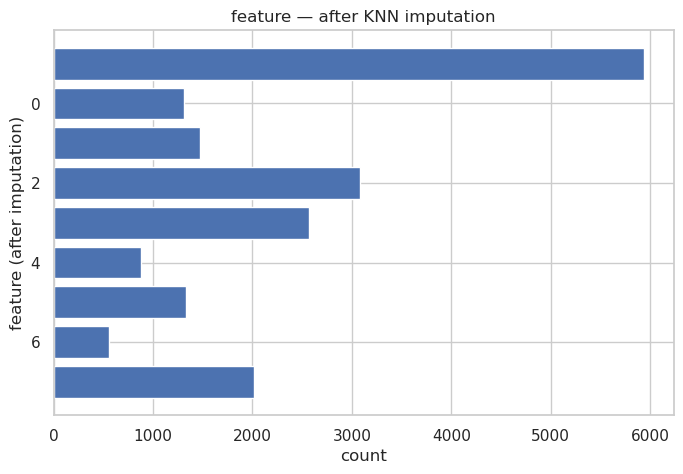

In [346]:
unique, counts = np.unique(size_encoded_viz, return_counts=True)

# sort by count descending
sort_idx = np.argsort(counts)[::-1]
unique = unique[sort_idx]
counts = counts[sort_idx]

# plot
plot_imputation(unique, counts)

In [347]:
X1 = gender_col.copy()
X2 = re_exp_col.copy()
X3 = en_uni_col.copy()
X4 = edu_level_col.copy()
X5 = major_col.copy()
X6 = exp_col.copy()
X7 = training_hour_log.copy()
X8 = city_dev_idx_col.copy()

X = np.column_stack([X1, X2, X3, X4, X5, X6, X7, X8])
X[:5]

array([[ 1.        ,  1.        ,  0.        ,  3.        ,  1.        ,
        21.        ,  3.58351894,  0.92      ],
       [ 1.        ,  0.        ,  0.        ,  3.        ,  1.        ,
        15.        ,  3.8501476 ,  0.776     ],
       [ 0.        ,  0.        ,  2.        ,  3.        ,  1.        ,
         5.        ,  4.41884061,  0.624     ],
       [ 0.        ,  0.        ,  0.        ,  3.        ,  0.        ,
         0.        ,  3.95124372,  0.789     ],
       [ 1.        ,  1.        ,  0.        ,  4.        ,  1.        ,
        21.        ,  2.07944154,  0.767     ]])

In [348]:
mask_known = size_encoded != -1
mask_missing = size_encoded == -1

X_known = X[mask_known]
y_known = size_encoded[mask_known]

X_missing = X[mask_missing]

##### KNN helper

In [349]:
def knn_predict(X_train, y_train, X_test, k=5):
    preds = np.zeros(len(X_test), dtype=int)
    for i, x in enumerate(X_test):
        # Euclidean distance
        dists = np.sqrt(np.sum((X_train - x)**2, axis=1))
        idx = np.argsort(dists)[:k]
        # majority vote
        votes = y_train[idx]
        values, counts = np.unique(votes, return_counts=True)
        preds[i] = values[np.argmax(counts)]
    return preds

In [350]:
y_pred = knn_predict(X_known, y_known, X_missing)
y_pred

array([3, 1, 0, ..., 2, 3, 1])

In [351]:
size_encoded[mask_missing] = y_pred

In [352]:
(size_encoded == -1).sum()

0

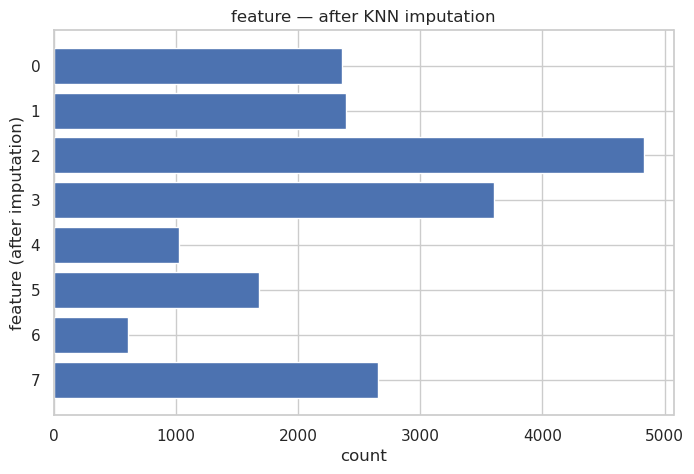

In [353]:
unique, counts = np.unique(size_encoded, return_counts=True)

# sort by count descending
sort_idx = np.argsort(counts)[::-1]
unique = unique[sort_idx]
counts = counts[sort_idx]

# plot
plot_imputation(unique, counts)

In [354]:
company_sz_col = size_encoded.copy()

#### 2.3.2.8 Company type

Since company_type contained 32% missing values and its distribution was highly imbalanced, simply filling missing values with the most frequent category (“Pvt Ltd”) would distort the dataset.


Instead, we used K-Nearest Neighbors imputation, using the other 8 features (x1 → x8) to infer the most probable company_type.
Each missing sample was assigned the majority class among its k=5 nearest neighbours in feature space.


This produces a more realistic and data-driven imputation while preserving relationships between company characteristics and company type.

In [355]:
company_type = col_arrays["company_type"]
np.unique(company_type)

array(['', 'Early Stage Startup', 'Funded Startup', 'NGO', 'Other',
       'Public Sector', 'Pvt Ltd'], dtype='<U23')

In [356]:
company_type[:10]

array(['', 'Pvt Ltd', '', 'Pvt Ltd', 'Funded Startup', '',
       'Funded Startup', 'Pvt Ltd', 'Pvt Ltd', 'Pvt Ltd'], dtype='<U23')

In [357]:
company_type = np.where(company_type == "", "Missing", company_type)

# Step 2: create numeric labels

mapping2 = {
    "Other": 0,
    "NGO": 1,
    "Early Stage Startup": 2,
    "Public Sector": 3,
    "Funded Startup": 4,
    "Pvt Ltd": 5,
    "Missing": -1,           # missing
}



company_type_ids = np.vectorize(mapping2.get)(company_type)
company_type_ids[:10]

array([-1,  5, -1,  5,  4, -1,  4,  5,  5,  5])

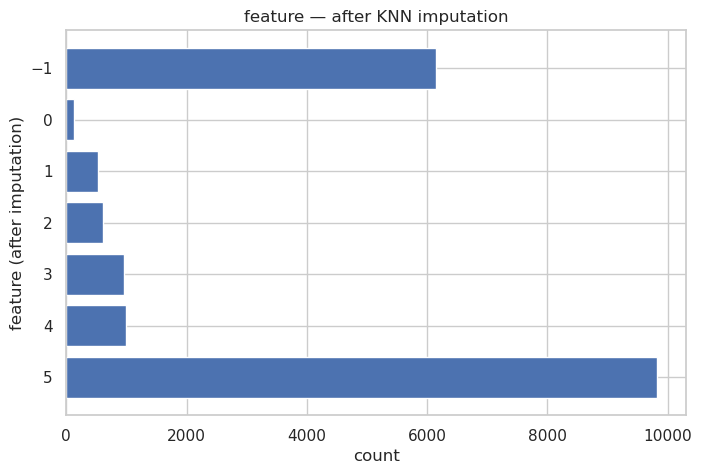

In [358]:
unique, counts = np.unique(company_type_ids, return_counts=True)

# sort by count descending
sort_idx = np.argsort(counts)[::-1]
unique = unique[sort_idx]
counts = counts[sort_idx]

# plot
plot_imputation(unique, counts)

In [359]:
missing_mask = (company_type == "Missing")

X_train = X[~missing_mask]
y_train = company_type_ids[~missing_mask]

X_test = X[missing_mask]

pred_missing = knn_predict(X_train, y_train, X_test, k=5)

# Fill back
company_type_ids_imputed = company_type_ids.copy()
company_type_ids_imputed[missing_mask] = pred_missing

company_type_ids_imputed[:10]

array([5, 5, 3, 5, 4, 5, 4, 5, 5, 5])

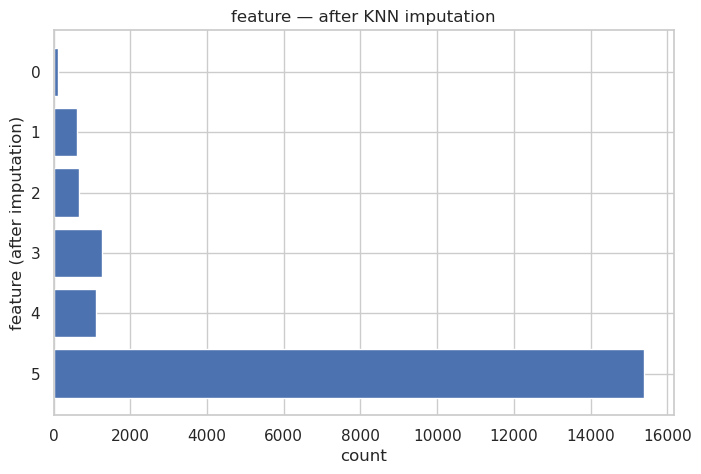

In [360]:
unique, counts = np.unique(company_type_ids_imputed, return_counts=True)

# sort by count descending
sort_idx = np.argsort(counts)[::-1]
unique = unique[sort_idx]
counts = counts[sort_idx]

# plot
plot_imputation(unique, counts)

In [361]:
company_type_col = company_type_ids_imputed.copy()

#### 2.3.2.9 Last new job

In [362]:
last_new_job_col = col_arrays["last_new_job"]
np.unique(last_new_job_col)

array(['', '1', '2', '3', '4', '>4', 'never'], dtype='<U23')

Because last_new_job measures the number of years since the candidate's previous job, and the feature has only 2% missing data, I encode missing values ("") as 0, meaning the candidate has recently changed jobs. This keeps the feature ordinal, preserves information, and avoids dropping useful samples.

In [363]:
last_new_job_col[:5]

array(['1', '>4', 'never', 'never', '4'], dtype='<U23')

In [364]:
v = col_arrays["last_new_job"].astype(str)

# Normalize missing
v = np.where(v == "", "never", v)

encoded_last_new_job = np.where(v == "never", 0,
                         np.where(v == ">4", 5, v))
encoded_last_new_job = encoded_last_new_job.astype(int)
encoded_last_new_job[:5]

array([1, 5, 0, 0, 4])

#### 2.3.2.10 City

In [365]:
city_col = col_arrays["city"]
np.unique(city_col)

array(['city_1', 'city_10', 'city_100', 'city_101', 'city_102',
       'city_103', 'city_104', 'city_105', 'city_106', 'city_107',
       'city_109', 'city_11', 'city_111', 'city_114', 'city_115',
       'city_116', 'city_117', 'city_118', 'city_12', 'city_120',
       'city_121', 'city_123', 'city_126', 'city_127', 'city_128',
       'city_129', 'city_13', 'city_131', 'city_133', 'city_134',
       'city_136', 'city_138', 'city_139', 'city_14', 'city_140',
       'city_141', 'city_142', 'city_143', 'city_144', 'city_145',
       'city_146', 'city_149', 'city_150', 'city_152', 'city_155',
       'city_157', 'city_158', 'city_159', 'city_16', 'city_160',
       'city_162', 'city_165', 'city_166', 'city_167', 'city_171',
       'city_173', 'city_175', 'city_176', 'city_179', 'city_18',
       'city_180', 'city_19', 'city_2', 'city_20', 'city_21', 'city_23',
       'city_24', 'city_25', 'city_26', 'city_27', 'city_28', 'city_30',
       'city_31', 'city_33', 'city_36', 'city_37', 'city_39

The city column contains over 120 unique categories, which makes one-hot encoding impractical. Instead, I apply frequency encoding using NumPy only. Each city is replaced by how many times it appears in the dataset. This preserves useful information without creating hundreds of sparse columns.

In [366]:
city_col[:5]

array(['city_103', 'city_40', 'city_21', 'city_115', 'city_162'],
      dtype='<U23')

In [367]:
unique, counts = np.unique(city_col, return_counts=True)


In [368]:
# 2. create mapping city to frequency
freq_map = dict(zip(unique, counts))

# 3. encode bằng vectorized numpy
# convert each city to count
freq_encoder = np.vectorize(lambda x: freq_map[x])
city_encoded = freq_encoder(city_col)
city_encoded[:5]

array([4355,   68, 2702,   54,  128])

Because the values in `city_encoded` is much higher than values in other colums, so I standardize the value in this column to make it normal distribution

In [369]:
def fit_standard_scaler(X):  # X: 2D numpy float array (n_samples, n_features)
    mean = np.mean(X, axis=0)
    std = np.std(X, axis=0)
    std_adj = np.where(std == 0, 1.0, std)  # avoid div0
    return mean, std_adj

def transform_standard_scaler(X, mean, std):
    return (X - mean) / std


In [370]:
mean, std = fit_standard_scaler(city_encoded)
print(f"Mean: {mean} | std: {std}")
city_encoded_scaled = transform_standard_scaler(city_encoded, mean, std)
city_encoded_scaled[:5]

Mean: 1709.7964296899468 | std: 1669.8916310361965


array([ 1.58405703, -0.98317543,  0.59417243, -0.99155921, -0.94724496])

In [371]:
freq_map

{'city_1': 26,
 'city_10': 86,
 'city_100': 275,
 'city_101': 75,
 'city_102': 304,
 'city_103': 4355,
 'city_104': 301,
 'city_105': 79,
 'city_106': 9,
 'city_107': 6,
 'city_109': 9,
 'city_11': 247,
 'city_111': 3,
 'city_114': 1336,
 'city_115': 54,
 'city_116': 128,
 'city_117': 13,
 'city_118': 27,
 'city_12': 13,
 'city_120': 6,
 'city_121': 3,
 'city_123': 79,
 'city_126': 28,
 'city_127': 10,
 'city_128': 92,
 'city_129': 3,
 'city_13': 48,
 'city_131': 9,
 'city_133': 10,
 'city_134': 43,
 'city_136': 586,
 'city_138': 120,
 'city_139': 5,
 'city_14': 28,
 'city_140': 1,
 'city_141': 27,
 'city_142': 53,
 'city_143': 41,
 'city_144': 29,
 'city_145': 63,
 'city_146': 8,
 'city_149': 102,
 'city_150': 65,
 'city_152': 51,
 'city_155': 14,
 'city_157': 22,
 'city_158': 49,
 'city_159': 94,
 'city_16': 1533,
 'city_160': 845,
 'city_162': 128,
 'city_165': 82,
 'city_166': 4,
 'city_167': 10,
 'city_171': 1,
 'city_173': 151,
 'city_175': 14,
 'city_176': 24,
 'city_179': 5,
 '

In [372]:
freq_map_py = {str(k): int(v) for k, v in freq_map.items()}

import json
file_path = "../data/processed/freq_encode.json"
with open(file_path, 'w') as json_file:
    json.dump(freq_map_py, json_file, indent=4)


In [373]:
with open("../data/processed/mean_std.txt", 'w') as f:
    f.write(f"{mean},{std}")

## 2.4 Final data after preprocessing

In [374]:
target = col_arrays["target"].astype(float)
target

array([1., 0., 0., ..., 0., 0., 0.])

In [375]:
final_data = np.column_stack([city_dev_idx_col, training_hour_log, 
                        gender_col, re_exp_col,
                        en_uni_col, edu_level_col, 
                        major_col, exp_col,
                        company_sz_col,company_type_col, 
                        encoded_last_new_job, city_encoded_scaled,target]).astype(float)
final_data

array([[ 0.92      ,  3.58351894,  1.        , ...,  1.        ,
         1.58405703,  1.        ],
       [ 0.776     ,  3.8501476 ,  1.        , ...,  5.        ,
        -0.98317543,  0.        ],
       [ 0.624     ,  4.41884061,  0.        , ...,  0.        ,
         0.59417243,  0.        ],
       ...,
       [ 0.92      ,  3.78418963,  1.        , ...,  4.        ,
         1.58405703,  0.        ],
       [ 0.802     ,  4.57471098,  1.        , ...,  2.        ,
        -0.91909942,  0.        ],
       [ 0.855     ,  4.84418709,  0.        , ...,  1.        ,
        -0.76579606,  0.        ]])

In [376]:
final_data = np.round(final_data, 3)

## 2.5 Save preprocessed data

In [377]:
np.savetxt("../data/processed/preprocessed_data.csv",
           final_data,
           delimiter=",",
           header= 'city_dev_index,training_hour,gender,relevent_exp,enrolled_uni,education_level,major,experience,company_size,company_type,last_new_job,city,target',
           comments="")